<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#K-means" data-toc-modified-id="K-means-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>K-means</a></span><ul class="toc-item"><li><span><a href="#K-means-clustering-on-the-handwritten-digits-data" data-toc-modified-id="K-means-clustering-on-the-handwritten-digits-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>K-means clustering on the handwritten digits data</a></span></li><li><span><a href="#Clustering-Performance-evaluation" data-toc-modified-id="Clustering-Performance-evaluation-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Clustering Performance evaluation</a></span><ul class="toc-item"><li><span><a href="#Adjusted-Rand-Index(ARI)" data-toc-modified-id="Adjusted-Rand-Index(ARI)-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Adjusted Rand Index(ARI)</a></span></li><li><span><a href="#Mutual-information-based-scores" data-toc-modified-id="Mutual-information-based-scores-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Mutual information based scores</a></span></li><li><span><a href="#Homogeneity,-completeness-and-V-measure" data-toc-modified-id="Homogeneity,-completeness-and-V-measure-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Homogeneity, completeness and V-measure</a></span></li><li><span><a href="#Silhouette-Coefficient" data-toc-modified-id="Silhouette-Coefficient-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Silhouette Coefficient</a></span></li></ul></li><li><span><a href="#Benchmark" data-toc-modified-id="Benchmark-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Benchmark</a></span></li><li><span><a href="#Visualize-the-results-on-PCA-reduced-data" data-toc-modified-id="Visualize-the-results-on-PCA-reduced-data-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Visualize the results on PCA-reduced data</a></span></li><li><span><a href="#References" data-toc-modified-id="References-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>References</a></span></li></ul></li></ul></div>

# K-means

K-means has three steps:
1. Choose the initial centroids, with the most basic method to choose $k$ samples from the dataset $X$.
2. Assign each sample to its nearest centroid
3. Create new centroids by taking the mean value of the samples assigned to each previous centroid

==> Repeat step 2 and step 3 until convergence. 

Given enough time, K-means will always converge, however this may be due to a local minimum.
One method to address this issue is the k-means++ initialization scheme `(init='k-means++')`. This initializes the centroids to be generally distant from each other. 

## K-means clustering on the handwritten digits data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
np.random.seed(42)

In [2]:
# Load the data
digits = load_digits()

In [3]:
#Standardize the dataset along any axis
#Center to the mean and component wise scale to unit variance.
data = scale(digits.data)

In [4]:
n_samples, n_features = data.shape
print(n_samples, n_features)

1797 64


We have 1797 samples. Each sample consists of 64 pixels (8x8) image.

In [5]:
sample_size = 300
labels = digits.target
n_digits = len(np.unique(labels))
n_digits

10

## Clustering Performance evaluation

Evaluating the performance of a clustering algorithm is not as trivial as counting the number of errors or the precision and recall of a supervised classification algorithm. In particular any evaluation metric should not take the absolute values of the cluster labels into account but rather if this clustering define separations of the data similar to some ground truth set of classes or satisfying some assumption such that members belong to the same class are more similar that members of different classes according to some similarity metric.


As the ground truth is known here, we also apply different cluster quality metrics to judge the goodness of fit of the cluster labels to the ground truth.

Cluster quality metrics evaluated:

### Adjusted Rand Index(ARI)

Given the knowledge of the ground truth class assignments `labels_true` and our clustering algorithm assignments of the same samples `labels_pred`, the adjusted Rand index is a function that measures the similarity of the two assignments, ignoring permutations and with chance normalization.

- **Random (uniform) label assignments have a ARI score close to 0.0** for any value of `n_clusters` and `n_samples` (which is not the case for raw Rand index or the V-measure for instance).
- **Bounded range [-1, 1]**: negative values are bad (independent labelings), similar clusterings have a positive ARI, 1.0 is the perfect match score.

- **No assumption is made on the cluster structure:** can be used to compare clustering algorithms such as k-means which assumes isotropic blob shapes with results of spectral clustering algorithms which can find cluster with “folded” shapes.

- Contrary to inertia, **ARI requires knowledge of the ground truth classes** while is almost never available in practice or requires manual assignment by human annotators (as in the supervised learning setting).

In [6]:
# Toy labels
labels_true = [0, 0, 0, 1, 1, 1]
labels_pred = [0, 0, 1, 1, 2, 2]

In [7]:
metrics.adjusted_rand_score(labels_true, labels_pred)

0.24242424242424246

In [8]:
# Perfect labeling is scored 1.0
metrics.adjusted_rand_score(labels_true, labels_true)

1.0

In [9]:
# Bad (e.g. independent labelings) have negative or close to 0.0 scores:
bad_labels_pred = [5, 4, 2, 3, 4, 5]
metrics.adjusted_rand_score(labels_true, bad_labels_pred)

-0.25

### Mutual information based scores 

The **Mutual Information** is a function that measures the **agreement** of the two assignments, ignoring permutations. Two different normalized versions of this measure are available, **Normalized Mutual Information(NMI) and Adjusted Mutual Information(AMI)**. NMI is often used in the literature while AMI was proposed more recently and is normalized against chance:


- **Random (uniform) label assignments have a AMI score close to 0.0** for any value of `n_clusters` and `n_samples` (which is not the case for raw Mutual Information or the V-measure for instance).
    
- **Bounded range [0, 1]**: Values close to zero indicate two label assignments that are largely independent, while values close to one indicate significant agreement. Further, values of exactly 0 indicate purely independent label assignments and a AMI of exactly 1 indicates that the two label assignments are equal (with or without permutation).
    
- **No assumption is made on the cluster structure**: can be used to compare clustering algorithms such as k-means which assumes isotropic blob shapes with results of spectral clustering algorithms which can find cluster with “folded” shapes.


In [10]:
metrics.adjusted_mutual_info_score(labels_true, labels_pred)

0.2250422831983088

In [11]:
metrics.mutual_info_score(labels_true, labels_pred)

0.46209812037329689

In [12]:
metrics.normalized_mutual_info_score(labels_true, labels_pred)

0.52954057805756183

In [13]:
metrics.mutual_info_score(labels_true, labels_true)

0.69314718055994518

In [14]:
metrics.adjusted_mutual_info_score(labels_true, labels_true)

1.0

In [15]:
metrics.normalized_mutual_info_score(labels_true, labels_true)

1.0

### Homogeneity, completeness and V-measure

Given the knowledge of the ground truth class assignments of the samples, it is possible to define some intuitive metric using conditional entropy analysis.

In particular Rosenberg and Hirschberg (2007) define the following two desirable objectives for any cluster assignment:

- **homogeneity**: each cluster contains only members of a single class.
- **completeness**: all members of a given class are assigned to the same cluster.

We can turn those concept as scores `homogeneity_score` and `completeness_score`. Both are bounded below by 0.0 and above by 1.0 (higher is better):

In [16]:
metrics.homogeneity_score(labels_true, labels_pred)

0.66666666666666685

In [17]:
metrics.completeness_score(labels_true, labels_pred)

0.420619835714305

In [18]:
metrics.v_measure_score(labels_true, labels_pred)

0.51580374297938891

### Silhouette Coefficient
If the ground truth labels are not known, evaluation must be performed using the model itself. The Silhouette Coefficient (sklearn.metrics.silhouette_score) is an example of such an evaluation, where a higher Silhouette Coefficient score relates to a model with better defined clusters. The Silhouette Coefficient is defined for each sample and is composed of two scores:

- a: The mean distance between a sample and all other points in the same class.
- b: The mean distance between a sample and all other points in the next nearest cluster.



- The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.
- The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.


## Benchmark

In [19]:
import time


def bench_k_means(estimator, name, data):
    start = time.time()
    estimator.fit(data)
    inertia = estimator.inertia_
    homo = metrics.homogeneity_score(labels, estimator.labels_)
    compl = metrics.completeness_score(labels, estimator.labels_)
    v_means = metrics.v_measure_score(labels, estimator.labels_)
    ARI = metrics.adjusted_rand_score(labels, estimator.labels_)
    AMI = metrics.adjusted_mutual_info_score(labels, estimator.labels_)
    silhouette = metrics.silhouette_score(
        data, estimator.labels_, metric='euclidean', sample_size=sample_size)
    total_time = time.time() - start
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f' %
          (name, total_time, inertia, homo, compl, v_means, ARI, AMI,
           silhouette))

In [20]:
print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')
print(82 * '_')
bench_k_means(
    KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
    name="k-means++",
    data=data)

bench_k_means(
    KMeans(init='random', n_clusters=n_digits, n_init=10),
    name="random",
    data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(
    KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
    name="PCA-based",
    data=data)
print(82 * '_')

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
__________________________________________________________________________________
k-means++	0.33s	69432	0.602	0.650	0.625	0.465	0.598	0.146
random   	0.20s	69694	0.669	0.710	0.689	0.553	0.666	0.147
PCA-based	0.06s	70804	0.671	0.698	0.684	0.561	0.668	0.118
__________________________________________________________________________________


From this table, we can see that the PCA-based k-means has better metrics compared to other initialization methods. 

## Visualize the results on PCA-reduced data

In [21]:
reduced_data = PCA(n_components=2).fit_transform(data)

In [22]:
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [23]:
from mlxtend.plotting import plot_decision_regions

In [24]:
y_kmeans = kmeans.predict(reduced_data)

In [25]:
centers = kmeans.cluster_centers_

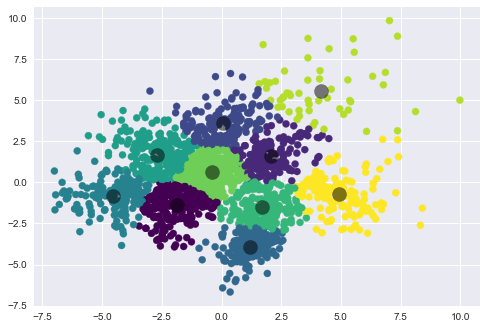

In [26]:
plt.scatter(reduced_data[:, 0], reduced_data[:,1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5)
plt.show()

## References

- [Clustering](http://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation)
- [A demo of K-Means clustering on the handwritten digits data](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py)
- [Clustering performance evaluation](http://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation)

In [27]:
%load_ext version_information
%version_information numpy, sklearn, matplotlib

Software versions
Python 3.6.3 64bit [MSC v.1900 64 bit (AMD64)]
IPython 6.2.1
OS Windows 10 10.0.16299 SP0
numpy 1.13.3
sklearn 0.19.1
matplotlib 2.1.1
Wed Jan 17 12:07:57 2018 Central Standard Time